In [2]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import keras
from keras.preprocessing import image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET
from tensorflow.keras.callbacks import TensorBoard

from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [1]:
import keras
model_name = "mutiple_Conv1D_8_inputs_scaled_modified"
model = keras.models.load_model("D:/Project2022/models/"+model_name+".h5")

In [3]:
import time
model_name = "baseline_raw"
NAME = model_name+"-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

In [5]:
CATEGORIES = ["covid", "normal"]
DATADIR = "D:/Project2022/res/split_dataset/original/train"

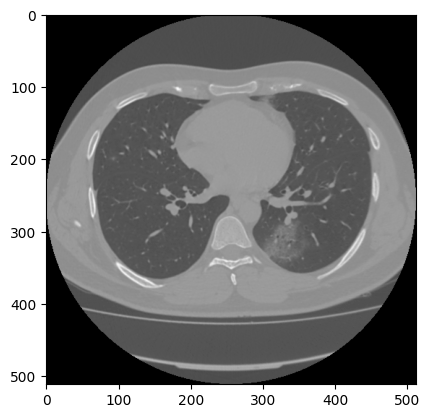

In [6]:
for categoty in CATEGORIES:
    path = os.path.join(DATADIR, categoty)  # path to Covid or Nprmal
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
        plt.imshow(img_array, cmap="gray")
        plt.show()

        break
    break

In [7]:
def pre_process_dataset(dataset_path):

    df_data = pd.DataFrame()
    #raw_image = []
    concat_data = []

    label = []

    for categoty in CATEGORIES:
        path = os.path.join(dataset_path, categoty)  
        
        class_num = CATEGORIES.index(categoty)
        

        print("Loading dataset: class",categoty)
        for img in tqdm(os.listdir(path)):

            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
                row = img_array.sum(axis=1)
                coloumn = img_array.sum(axis=0)
                

                concat = np.concatenate((row, coloumn))

                concat_data.append(concat)
                label.append(class_num)
                
            except Exception as e:
                pass
    
    #df_data["raw data"] = raw_image
    df_data["concat_data"] = concat_data
   
    df_data["label"] = label
    

    return df_data

In [8]:
dataset_df = pre_process_dataset(DATADIR)

Loading dataset: class covid


  0%|          | 0/5719 [00:00<?, ?it/s]

Loading dataset: class normal


  0%|          | 0/5514 [00:00<?, ?it/s]

In [9]:
dataset_df.head()

,concat_data,label
0,"[2494, 4356, 5604, 6526, 7444, 8223, 8843, 962...",0
1,"[1016, 1052, 1036, 1028, 1015, 1028, 1031, 101...",0
2,"[988, 1056, 1045, 1068, 1046, 1081, 1018, 1114...",0
3,"[960, 989, 980, 984, 984, 980, 984, 994, 990, ...",0
4,"[1088, 1108, 1106, 1074, 1077, 1078, 1076, 109...",0


In [10]:
# 70:30 split
df_train, df_val = train_test_split(dataset_df, test_size=0.3, random_state=0)

In [11]:
df_train["label"].value_counts()

0    4041
1    3822
Name: label, dtype: int64

In [12]:
print("No of Training samples:",len(df_train))
print("No of Validation samples:",len(df_val))

No of Training samples: 7863
No of Validation samples: 3370


In [13]:
df_train["concat_data"][0].shape

(1024,)

In [14]:
from sklearn import preprocessing

def process_data(dataset_df):
    
    row = dataset_df["concat_data"].values
    


    # global
    X1 = [img.tolist() for img in row]
   


    X1 = np.array(X1)
   

    
    #normalize the inputs
    X1 = preprocessing.normalize(X1)
    
    #reshape the inputs
    X1 = np.expand_dims(X1, axis=-1)
    


    y = np.array(dataset_df["label"].values)
    y = np.expand_dims(y, axis=-1)


    print("X1 shape", X1.shape)
    print("Y shape", y.shape)

   
    return X1, y

In [16]:
print("Training samples:")
X1_train, Y_train = process_data(df_train)

print("\nValidation samples:")
X1_val, Y_val = process_data(df_val)


Training samples:
X1 shape (7863, 1024, 1)
Y shape (7863, 1)

Validation samples:
X1 shape (3370, 1024, 1)
Y shape (3370, 1)


In [17]:
def conv1D_layer(input, nodes):
    #Input(shape=(367,1))
    #input_layer = Input(shape=inputSize)
    #kernel size- 5
    # nodes - 16
    conv1 = Conv1D(nodes, kernel_size=5, activation='relu')(input)
    drop1 = Dropout(0.25)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat = Flatten()(pool1)

    return flat


In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(1024, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Modified

In [20]:
# first input model
row = Input(shape=(1024,1))
flat_row = conv1D_layer(row, 16)

#####################################################################
hidden_all_1 = Dense(32, activation='relu')(flat_row)
#16
hidden_all_2 = Dense(16, activation='relu')(hidden_all_1)

output = Dense(1, activation='sigmoid')(hidden_all_2)
model = Model(inputs=[row], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize layers
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1020, 16)          96        
                                                                 
 dropout_1 (Dropout)         (None, 1020, 16)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 510, 16)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8160)              0         
                                                                 
 dense_3 (Dense)             (None, 32)                261152    
                                                           

In [21]:

BATCH_SIZE = 128
EPOCHS = 500
history = model.fit(
    [X1_train],
    Y_train,
    BATCH_SIZE,
    EPOCHS,
    validation_data=([X1_val], Y_val),
    callbacks=[tensorboard])

model.save("D:/Project2022/models/less_complex/"+model_name+".h5")

Epoch 1/500
62/62 [==============================] - 5s 23ms/step - loss: 0.6608 - accuracy: 0.5834 - val_loss: 0.6218 - val_accuracy: 0.7700
Epoch 2/500
62/62 [==============================] - 1s 18ms/step - loss: 0.5519 - accuracy: 0.7659 - val_loss: 0.5108 - val_accuracy: 0.7685
Epoch 3/500
62/62 [==============================] - 1s 18ms/step - loss: 0.4867 - accuracy: 0.7842 - val_loss: 0.4768 - val_accuracy: 0.7902
Epoch 4/500
62/62 [==============================] - 1s 15ms/step - loss: 0.4638 - accuracy: 0.7932 - val_loss: 0.4609 - val_accuracy: 0.7985
Epoch 5/500
62/62 [==============================] - 1s 15ms/step - loss: 0.4543 - accuracy: 0.7986 - val_loss: 0.4610 - val_accuracy: 0.7872
Epoch 6/500
62/62 [==============================] - 1s 15ms/step - loss: 0.4453 - accuracy: 0.7975 - val_loss: 0.4433 - val_accuracy: 0.8098
Epoch 7/500
62/62 [==============================] - 1s 15ms/step - loss: 0.4307 - accuracy: 0.8090 - val_loss: 0.4378 - val_accuracy: 0.8122
Epoch 

In [15]:
model.save("D:/Project2022/models/"+model_name+".h5")

ImportError: `save_model()` using h5 format requires h5py. Could not import h5py.

In [7]:
#model = keras.models.load_model("D:/Project2022/models/image/raw_500.h5")

#from tensorflow import keras
bing = keras.models.load_model('D:/Project2022/models/image/raw_500.h5')
bing.save(model_name+".h5")


ImportError: Filepath looks like a hdf5 file but h5py is not available. filepath=D:/Project2022/models/image/raw_500.h5

In [8]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


# Evaluate the Model using test data

In [22]:
Test_DATADIR = "D:/Project2022/res/split_dataset/original/test"
dataset_df = pre_process_dataset(Test_DATADIR)


Loading dataset: class covid


  0%|          | 0/1430 [00:00<?, ?it/s]

Loading dataset: class normal


  0%|          | 0/1379 [00:00<?, ?it/s]

In [23]:
print("No of test sample:", len(dataset_df))

No of test sample: 2809


In [24]:
X1_test, Y_test = process_data(dataset_df)

X1 shape (2809, 1024, 1)
Y shape (2809, 1)


In [25]:
# test loss, test accuracy
accuracy = model.evaluate([X1_test], Y_test, batch_size=100, verbose=0)

In [30]:
print("Test acuuracy", accuracy[1])
print("Test loss", accuracy[0])

Test acuuracy 0.9366322755813599
Test loss 0.19065405428409576


In [27]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict([X1_test]) > 0.5).astype("int32")

88/88 [==============================] - 0s 3ms/step


In [28]:
print(classification_report(Y_test, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.96      0.92      0.94      1430
      Normal       0.92      0.96      0.94      1379

    accuracy                           0.94      2809
   macro avg       0.94      0.94      0.94      2809
weighted avg       0.94      0.94      0.94      2809



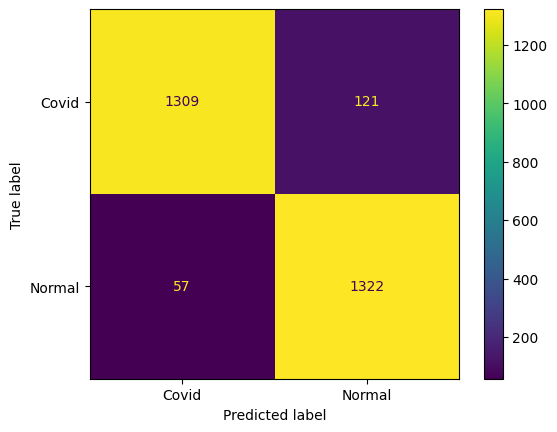

In [29]:
cm = confusion_matrix(Y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()
